<a href="https://colab.research.google.com/github/williamfrankholland/MMAI-Deep-Learning/blob/main/colab/Waste_Classification_ResNet_Bill_cat_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install focal-loss

import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv3D, Flatten, MaxPooling2D, AveragePooling2D

from sklearn.utils import shuffle
from tensorflow.keras import Model

from sklearn.metrics import classification_report

from focal_loss import SparseCategoricalFocalLoss

SHAPE_SIZE = 180


     |████████████████████████████████| 462 kB 7.0 MB/s 


In [ ]:
# Mount the google drive where the images are stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define which directory to access the file from
imdir = '/content/gdrive/MyDrive/MMAI 894 Team Project/data_final/'

# Load images with a standard size
image_size = (SHAPE_SIZE, SHAPE_SIZE)

# Set up the bacth size for latter processing
batch_size = 32

# Create a data ierator to allow images to be processed in batches avoiding the
# need for all images to be loaded in memory
total_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir,
    label_mode="int",
    subset=None,
    seed=1337,
    image_size=image_size,
    batch_size=None,
    shuffle=False
)




Found 10154 files belonging to 5 classes.


In [ ]:
# Check the number of images loaded
print(total_ds)
print(total_ds.cardinality().numpy())

<PrefetchDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
10154


In [ ]:
# Function to create a train, val, test split from a data set object (taken from Stack Overflow and modified)
def get_dataset_partitions_tf(ds, ds_size, train_split=0.5, val_split=0.2, test_split=0.3, shuffle=True, shuffle_size=10000, batch_size=32):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        # Note must set reshuffle_each_iteration to False to avoid data leakage
        ds = ds.shuffle(shuffle_size, seed=12, reshuffle_each_iteration = False)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_size)
    test_ds = ds.skip(train_size).skip(val_size).batch(batch_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
# Get the data set size to calculate the right split
# When batched this is the number of batches not item count
batch_count = total_ds.cardinality().numpy()
print(batch_count)

# Split the data into three parts train=50% val=20% test-20%
train_ds, val_ds, test_ds = get_dataset_partitions_tf(total_ds, batch_count, train_split=0.5, 
                                                      val_split=0.3, test_split=0.2, shuffle=True, shuffle_size=10000, batch_size=batch_size)

# Check that the split worked
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())


10154
159
96
64


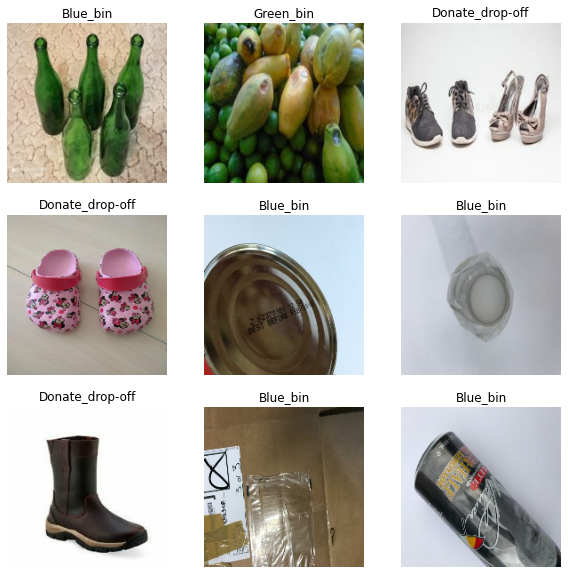

In [ ]:
# Get the first batch of 32 then print the first 9 items
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.title(total_ds.class_names[labels[i]])
        plt.axis("off")

In [ ]:
def build_model():


    # Create the base model layers - need to use ResNet50V2
    base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(SHAPE_SIZE, SHAPE_SIZE, 3))
    base_model.trainable = False

    # Create the input layer with the picture dimention and 3 channels
    input_layer = keras.layers.Input([SHAPE_SIZE, SHAPE_SIZE, 3])

    # Add a small amount of randon translation
    x = keras.layers.RandomTranslation( height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))(input_layer)

    # Call the model specific pre-processing layer
    pre_process = keras.applications.resnet_v2.preprocess_input(x)

    # Add the initial layers to the base model
    x = base_model(pre_process)
    
    # Conv2+ReLU: [5x5, 32] MaxPooling: [2x2] strides=2
    x = keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu", name="Conv2d-1", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-1", padding="same", strides=2)(x)

    # Conv2+ReLU: [3x3, 64] MaxPooling: [4x4] strides=2
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="Conv2d-2", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-2", padding="same", strides=2)(x)

    # Conv2+ReLU: [3x3, 256] MaxPooling: [2x2] strides=2
    x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", name="Conv2d-3", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-3", padding="same", strides=2)(x)


    # Conv2+ReLU: [3x3, 512] MaxPooling: [2x2] strides=2
    x = keras.layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation="relu", name="Conv2d-5", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same", name="Pool-5", strides=2)(x)
    
    # Flatten out the images before we pass to the dense layers
    x = keras.layers.Flatten()(x)

    # Start with more neurons 256
    x = keras.layers.Dense(256, activation="relu", name="Denselayer1", kernel_regularizer=keras.regularizers.l2(0.05))(x)
    # Drop rate = 25%
    #x=keras.layers.Dropout(rate=0.4, name="drop_1_25")(x)

    # Narrow the data size 128
    x=keras.layers.Dense(128, activation="relu", name="Denselayer2", kernel_regularizer=keras.regularizers.l2(0.05))(x)
    # Drop rate = 25%
    #x=keras.layers.Dropout(rate=0.4, name="drop_2_25")(x)

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = keras.initializers.GlorotNormal(seed=42)

    #output layer for 17 classes, using softmax activation
    output_layer = Dense(17, 
                    activation='softmax',
                    kernel_initializer=weight_initializer,  
                    kernel_constraint=None,
                    )(x)

    model = Model(input_layer, output_layer)
    model.summary()

    return model

def compile_model(model):

    model.compile(
       #use catgorical crossentropy loss
       #loss=keras.losses.categorical_crossentropy,

       loss=SparseCategoricalFocalLoss(gamma=3),

        # Current version
        #loss=keras.losses.sparse_categorical_crossentropy,

        #use Adam gradient descent optimizer
        optimizer=keras.optimizers.Adam(1e-3),
       
        #use accuracy as a metric
        metrics=['accuracy']
    )

    return model

def train_model(model, train, val, epochs = 20):


    # Prevent an overfit by stopping early
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    #fit model with train data
    history = model.fit(
        train,
    
        #use 128 batch size, 12 epochs
        batch_size = 128,
        epochs = epochs,
        
        #verbose training, including validation data
        verbose = 2,
        validation_data = val,
        callbacks=[callback]
    )
    return model, history


def eval_model(model, test):

    #evaluate model with test data
    test_loss, test_accuracy = model.evaluate(
        test,
        verbose = 2
    )

    return test_loss, test_accuracy

def tune_model(model, train, val, epochs=5, l_rate=5e-5):
    # Unfreeze the base model
    model.trainable = True

    # Small learning rate to prevent over fitting
    model.compile( 
                  keras.optimizers.Adam(learning_rate=l_rate),
                  #loss=keras.losses.sparse_categorical_crossentropy,
                  loss=SparseCategoricalFocalLoss(gamma=3),
                  metrics=['accuracy'])

    train_model(model, train, val, epochs = epochs)
    return model

In [ ]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, train_ds, val_ds)

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_translation (RandomT  (None, 180, 180, 3)      0         
 ranslation)                                                     
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        2356480

In [ ]:
# Now fine tune the model with a small learning rate
l_rate=5e-5
model = tune_model(model, train_ds, val_ds, epochs=10, l_rate=l_rate)
test_loss, test_accuracy = eval_model(model, test_ds)


Epoch 1/10
159/159 - 48s - loss: 0.1105 - accuracy: 0.9295 - val_loss: 0.1295 - val_accuracy: 0.9143 - 48s/epoch - 301ms/step
Epoch 2/10
159/159 - 41s - loss: 0.0437 - accuracy: 0.9773 - val_loss: 0.1088 - val_accuracy: 0.9307 - 41s/epoch - 256ms/step
Epoch 3/10
159/159 - 41s - loss: 0.0269 - accuracy: 0.9909 - val_loss: 0.1032 - val_accuracy: 0.9330 - 41s/epoch - 256ms/step
Epoch 4/10
159/159 - 41s - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.1030 - val_accuracy: 0.9238 - 41s/epoch - 256ms/step
Epoch 5/10
159/159 - 41s - loss: 0.0225 - accuracy: 0.9945 - val_loss: 0.1132 - val_accuracy: 0.9206 - 41s/epoch - 256ms/step
Epoch 6/10
159/159 - 41s - loss: 0.0198 - accuracy: 0.9959 - val_loss: 0.1076 - val_accuracy: 0.9251 - 41s/epoch - 256ms/step
Epoch 7/10
159/159 - 41s - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.1092 - val_accuracy: 0.9222 - 41s/epoch - 256ms/step
Epoch 8/10
159/159 - 41s - loss: 0.0186 - accuracy: 0.9953 - val_loss: 0.1044 - val_accuracy: 0.9268 - 41s/epoch - 256

In [ ]:
print(total_ds.class_names)

['Black_bin', 'Blue_bin', 'Donate_drop-off', 'Green_bin', 'Hazardous_waste']


In [ ]:
# Extract the labels from the test data set
Y_test_class = tf.concat([labels for images, labels in test_ds], axis=0)

In [ ]:
from tensorflow.keras.backend import argmax

# Get the class with the highest probability
Y_pred_class = argmax(model.predict(test_ds))


In [ ]:
# Look at the lables in predict and test
print(np.unique(Y_pred_class))
print(np.unique(Y_test_class))

# Make sure the first 20 look reasonable
print(Y_pred_class[0:20])
print(Y_test_class[0:20])

[0 1 2 3 4]
[0 1 2 3 4]
tf.Tensor([1 1 1 1 1 2 4 3 4 1 1 1 1 1 3 2 2 2 3 1], shape=(20,), dtype=int64)
tf.Tensor([1 1 1 1 4 2 4 3 4 1 1 1 1 1 3 2 2 2 3 1], shape=(20,), dtype=int32)


In [ ]:
# Import libraries for Seaborn grpahs

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)

label_len = len(total_ds.class_names)
print(label_len)

5


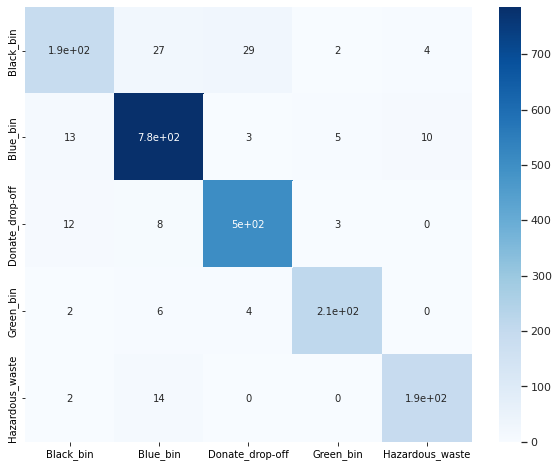

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix from the test results
cm=confusion_matrix(Y_test_class,Y_pred_class, labels = list(np.arange(label_len)) ) # normalize='all'
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = total_ds.class_names 
df_cm.index = total_ds.class_names

# Plot the confusion matrix as a heat map
fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues")
plt.show()

In [ ]:
print(classification_report(Y_test_class,Y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       254
           1       0.93      0.96      0.95       816
           2       0.93      0.96      0.94       527
           3       0.95      0.95      0.95       224
           4       0.93      0.92      0.93       210

    accuracy                           0.93      2031
   macro avg       0.92      0.91      0.92      2031
weighted avg       0.93      0.93      0.93      2031

